# Pipeline

This pipeline includes all steps in a single notebook (For Google Colab setup and testing purposes). It is currently a work-in-progress, for now, please visit ./notebooks for the individual steps.

In [828]:
import sys

CURRENT_ENVIRONMENT = "GOOGLE_COLAB" if "google.colab" in sys.modules else "LOCAL"

In [829]:
import os
import shutil

if CURRENT_ENVIRONMENT == "GOOGLE_COLAB":
    from google.colab import drive

    # Mount Google Drive
    drive.mount('/content/drive', force_remount=True)

    # If the utils directory exists, delete it
    if os.path.exists('/content/utils'):
        shutil.rmtree('/content/utils')

    # Copy the utils.zip file to the current directory
    !cp /content/drive/MyDrive/utils.zip /content/utils.zip

    # Unzip the utils.zip file
    !unzip -q /content/utils.zip -d /content/utils

    # Delete the utils.zip file
    !rm /content/utils.zip

In [830]:
if CURRENT_ENVIRONMENT == "LOCAL":
    from utils.constants import *
elif CURRENT_ENVIRONMENT == "GOOGLE_COLAB":
    from utils.constants_colab import *

In [831]:
if ENVIRONMENT == "LOCAL":
    from utils.cache import reload_custom_libraries

    # Refresh library cache
    reload_custom_libraries()

In [832]:
import os
from utils.zipper import read_file, write_file

install_file = os.path.join(DATA_DIR, "install.txt")

# Create the directory if it does not exist
os.makedirs(DATA_DIR, exist_ok=True)

install_content = read_file(install_file)

if ENVIRONMENT == "LOCAL":
    requirements_file = "requirements.txt"
    requirements_content = read_file(requirements_file)
    if install_content != requirements_content:
        get_ipython().system("pip install -r requirements.txt")
        write_file(install_file, requirements_content)
elif ENVIRONMENT == "GOOGLE_COLAB":
    if install_content != "imagehash":
        get_ipython().system("pip install imagehash")
        write_file(install_file, "imagehash")

In [833]:
if ENVIRONMENT == "LOCAL":
    from utils.zipper import zip_dir

    # Zip the reloaded libraries to be used in Google Colab
    zip_dir(UTILS_DIR, f"{ZIPPED_RESOURCES_DIR}/utils.zip")

In [834]:
from utils.converter import convert_to_df


train_df = convert_to_df(DATASET_DIR, TRAIN_DATA_CSV)
cleaned_train_df = convert_to_df(CLEANED_DATASET_DIR, CLEANED_TRAIN_DATA_CSV)
processed_train_df = convert_to_df(PROCESSED_DATASET_DIR, PROCESSED_TRAIN_DATA_CSV)

CSV file already exists at ./data/datasets/raw.csv. Loading from cache...
CSV file already exists at ./data/datasets/cleaned.csv. Loading from cache...
CSV file already exists at ./data/datasets/processed.csv. Loading from cache...


In [835]:
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print(
    "GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE"
)

TF version: 2.16.1
Hub version: 0.16.1
GPU is NOT AVAILABLE


In [836]:
from tqdm import tqdm
import os
from utils.zipper import unzip_file, remove_if_exists, move_dir

# if force unzip or DATASET_DIR doesn't exist or empty
if FORCE_UNZIP or not tf.io.gfile.exists(DATASET_DIR):
    if not os.path.isdir(f"{DATASET_EXTRACT_DIR}/Furniture_Data"):
        print("Starting unzip process...")
        # Unzip the file
        unzip_file(DATASET_ZIP, DATASET_EXTRACT_DIR)
        print("Unzip process completed.")

    # Check if the new dataset already directory exists
    print("Checking for existing train dataset directory...")
    remove_if_exists(DATASET_DIR)

    print("Checking for `__MACOSX` directory...")
    # Check if the `__MACOSX` directory exists
    remove_if_exists(MACOS_DIR)

    # Move the extracted dataset to the correct directory
    print("Moving extracted dataset to the correct directory...")
    move_dir(f"{DATASET_EXTRACT_DIR}/Furniture_Data", DATASET_DIR)
    print("Dataset moved successfully.")
else:
    print("Skipping unzip process as DATASET_DIR exists and FORCE_UNZIP is not set.")

Skipping unzip process as DATASET_DIR exists and FORCE_UNZIP is not set.


In [837]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import display
from PIL import Image
from PIL import ImageFile
import os, sys
from tqdm.auto import tqdm
from utils.image_process import (
    get_category_styles,
    process_images,
    get_category_image_paths,
    resize_images,
    augment_images,
)

In [838]:
data = tf.keras.utils.image_dataset_from_directory(DATASET_DIR)

Found 90082 files belonging to 6 classes.


In [839]:
categories = ["beds", "chairs", "dressers", "lamps", "sofas", "tables"]
paths = {
    category: get_category_image_paths(DATASET_DIR, category) for category in categories
}
print("Successfully extracted all paths!")

Getting image path for category 'beds':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'chairs':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'dressers':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'lamps':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'sofas':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'tables':   0%|          | 0/17 [00:00<?, ?it/s]

Successfully extracted all paths!


In [840]:
# Calculate the total
total = 0

# Print the amount for each category
for category in categories:
    amount = len(paths[category])
    print(f"Amount of {category}: {amount}")
    total += amount

# Print the total
print("Total:", total)

Amount of beds: 6578
Amount of chairs: 22053
Amount of dressers: 7870
Amount of lamps: 32402
Amount of sofas: 4080
Amount of tables: 17100
Total: 90083


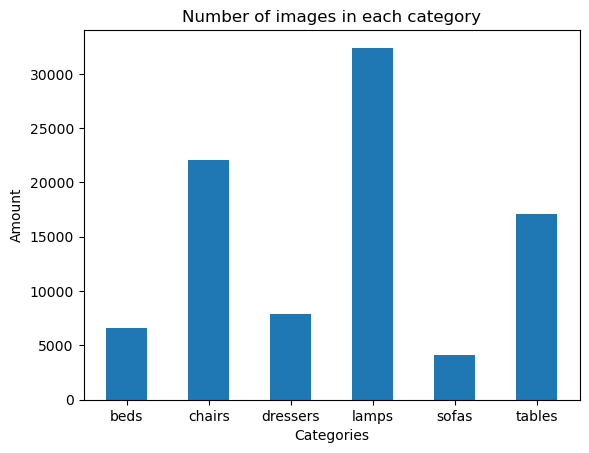

In [841]:
plt.bar(paths.keys(), [len(v) for v in paths.values()], width=0.5)
plt.title("Number of images in each category")
plt.xlabel("Categories")
plt.ylabel("Amount")
plt.show()

## Get duplicate images from each categories
### Check duplicants and remove duplicants from each categories

In [842]:
# Create a new dictionary to store the paths and image sizes for each category
data = {}
for category, items in paths.items():
    imageSizes = process_images(items, category, DATASET_DIR)
    data[category] = {
        "paths": get_category_image_paths(CLEANED_DATASET_DIR, category),
        "imageSizes": imageSizes,
    }

paths = {
    category: get_category_image_paths(CLEANED_DATASET_DIR, category)
    for category in categories
}

print("Successfully extracted all paths and image sizes!")

Loaded image sizes from cache.
(350, 350) pixels:  41
(224, 224) pixels:  6537
Category 'beds', Style 'Asian': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Beach': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Contemporary': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Craftsman': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Eclectic': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Farmhouse': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Industrial': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Mediterranean': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', S

Getting image path for category 'beds':   0%|          | 0/17 [00:00<?, ?it/s]

Loaded image sizes from cache.
(350, 350) pixels:  22053
Category 'chairs', Style 'Asian': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Beach': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Contemporary': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Craftsman': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Eclectic': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Farmhouse': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Industrial': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Mediterranean': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style

Getting image path for category 'chairs':   0%|          | 0/17 [00:00<?, ?it/s]

Loaded image sizes from cache.
(350, 350) pixels:  7870
Category 'dressers', Style 'Asian': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Beach': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Contemporary': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Craftsman': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Eclectic': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Farmhouse': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Industrial': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Mediterranean': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 

Getting image path for category 'dressers':   0%|          | 0/17 [00:00<?, ?it/s]

Loaded image sizes from cache.
(350, 350) pixels:  32401
Category 'lamps', Style 'Asian': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Beach': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Contemporary': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Craftsman': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Eclectic': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Farmhouse': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Industrial': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Mediterranean': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Midcent

Getting image path for category 'lamps':   0%|          | 0/17 [00:00<?, ?it/s]

Loaded image sizes from cache.
(350, 350) pixels:  4080
Category 'sofas', Style 'Asian': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Beach': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Contemporary': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Craftsman': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Eclectic': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Farmhouse': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Industrial': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Mediterranean': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Midcentu

Getting image path for category 'sofas':   0%|          | 0/17 [00:00<?, ?it/s]

Loaded image sizes from cache.
(350, 350) pixels:  17099
(500, 446) pixels:  1
Category 'tables', Style 'Asian': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Beach': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Contemporary': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Craftsman': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Eclectic': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Farmhouse': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Industrial': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Mediterranean': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Ca

Getting image path for category 'tables':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'beds':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'chairs':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'dressers':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'lamps':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'sofas':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'tables':   0%|          | 0/17 [00:00<?, ?it/s]

Successfully extracted all paths and image sizes!


### Recheck the categories after removing duplicants

In [843]:
# Calculate the total
total = 0

# Print the amount for each category
for category in categories:
    amount = len(data[category]["paths"])
    print(f"Amount of {category}: {amount}")
    total += amount

# Print the total
print("Total:", total)

Amount of beds: 6542
Amount of chairs: 20067
Amount of dressers: 6649
Amount of lamps: 22980
Amount of sofas: 3385
Amount of tables: 16070
Total: 75693


### Visualization

Text(0, 0.5, 'Amount')

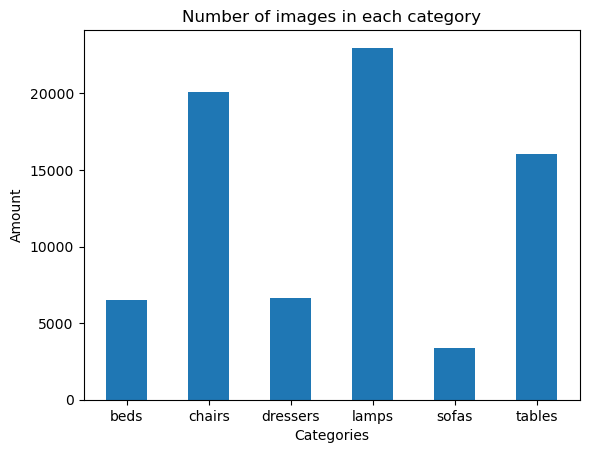

In [844]:
plt.bar(
    categories, [len(data[category]["paths"]) for category in categories], width=0.5
)
plt.title("Number of images in each category")
plt.xlabel("Categories")
plt.ylabel("Amount")

-   In the plot we can see the differences between of the amount in different columns. Because of that, we will need to check for the imbalances of our dataset

## Get different amount of image size of each category

In [845]:
# Define a dictionary to store the dataframes
# each category in df_dims is data[category][imageSizes]
df_dims = {
    category: pd.DataFrame(data[category]["imageSizes"], columns=["width", "height"])
    for category in categories
}

print("Successfully extracted all dimensions!")

Successfully extracted all dimensions!


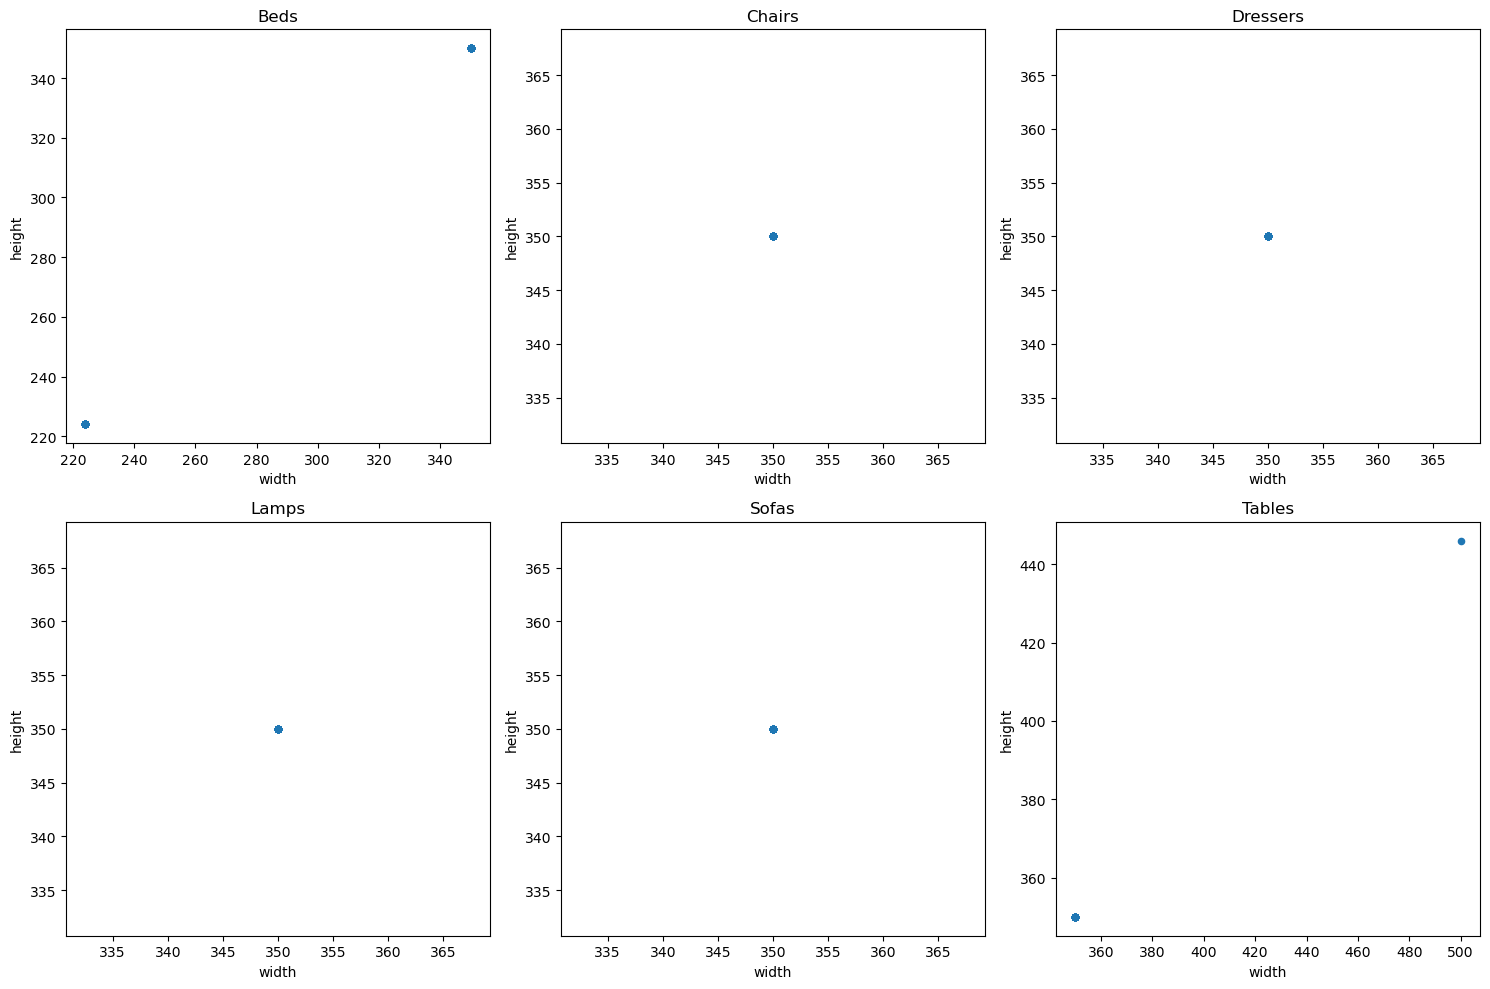

In [846]:
import matplotlib.pyplot as plt

# Define the number of rows and columns for the subplot grid
n_rows = 2
n_cols = 3

# Create the subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))

# Flatten the axes array
axs = axs.flatten()

# Iterate over the categories and axes
for ax, category in zip(axs, categories):
    # Create the scatter plot for the current category
    df_dims[category].plot.scatter(
        x="width", y="height", ax=ax, title=category.capitalize()
    )

# Adjust the layout
plt.tight_layout()
plt.show()

In [847]:
# Iterate over the categories
for category in categories:
    print(category.capitalize())
    display(df_dims[category].describe().T)

Beds


,count,mean,std,min,25%,50%,75%,max
width,6578.0,224.785345,9.917241,224.0,224.0,224.0,224.0,350.0
height,6578.0,224.785345,9.917241,224.0,224.0,224.0,224.0,350.0


Chairs


,count,mean,std,min,25%,50%,75%,max
width,22053.0,350.0,0.0,350.0,350.0,350.0,350.0,350.0
height,22053.0,350.0,0.0,350.0,350.0,350.0,350.0,350.0


Dressers


,count,mean,std,min,25%,50%,75%,max
width,7870.0,350.0,0.0,350.0,350.0,350.0,350.0,350.0
height,7870.0,350.0,0.0,350.0,350.0,350.0,350.0,350.0


Lamps


,count,mean,std,min,25%,50%,75%,max
width,32401.0,350.0,0.0,350.0,350.0,350.0,350.0,350.0
height,32401.0,350.0,0.0,350.0,350.0,350.0,350.0,350.0


Sofas


,count,mean,std,min,25%,50%,75%,max
width,4080.0,350.0,0.0,350.0,350.0,350.0,350.0,350.0
height,4080.0,350.0,0.0,350.0,350.0,350.0,350.0,350.0


Tables


,count,mean,std,min,25%,50%,75%,max
width,17100.0,350.008772,1.147079,350.0,350.0,350.0,350.0,500.0
height,17100.0,350.005614,0.734130,350.0,350.0,350.0,350.0,446.0


- The dataset contains 6 categories of items with 90083 items total
- The dataset contains all file with JPEG type
- The dataset contains image mainly in two dimensions: 224x224 and 350x350. However there are one anomaly dimensions in the table category which is: 500x446

## Data Preprocessing

We will start with resizing all images to 350x350. Here are some reasons:
- The vast majority of the images are already at 350x350. Upscaling the smaller images will introduce minimal distortion compared to downscaling the majority to 224x224.
- Upscaling generally retains more information from the original image than downscaling. While some interpolation artifacts might be introduced, they are less likely to significantly impact model performance compared to the information loss from downscaling.
- The single image with a size of 500x448 is an outlier. which we can either upscale it to match the majority or exclude it from our dataset without significant impact.

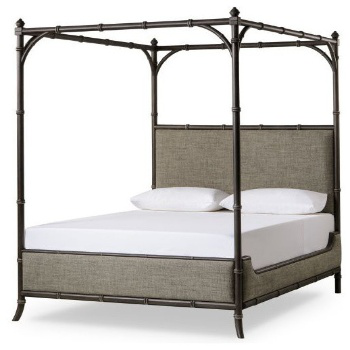

In [848]:
Image.open(data["beds"]["paths"][1])

In [849]:
for category in categories:
    print(f"Number of images in category '{category}': {len(data[category]['paths'])}")

# Total number of images
total = sum(len(data[category]["paths"]) for category in categories)
print(f"Total number of images: {total}")

Number of images in category 'beds': 6542
Number of images in category 'chairs': 20067
Number of images in category 'dressers': 6649
Number of images in category 'lamps': 22980
Number of images in category 'sofas': 3385
Number of images in category 'tables': 16070
Total number of images: 75693


In [850]:
# check all file extensions in data[*]["paths"]
for category in categories:
    print(f"Checking file extensions for category '{category}'")
    for img_path in data[category]["paths"]:
        if not img_path.endswith((".jpg", ".jpeg", ".png")):
            print(f"Invalid file extension: {img_path}")
            break
    print(f"All file extensions are valid for category '{category}'")

Checking file extensions for category 'beds'
All file extensions are valid for category 'beds'
Checking file extensions for category 'chairs'
All file extensions are valid for category 'chairs'
Checking file extensions for category 'dressers'
All file extensions are valid for category 'dressers'
Checking file extensions for category 'lamps'
All file extensions are valid for category 'lamps'
Checking file extensions for category 'sofas'
All file extensions are valid for category 'sofas'
Checking file extensions for category 'tables'
All file extensions are valid for category 'tables'


In [851]:
size = (350, 350)

for category in data.keys():
    resize_images(data, category, size)

In [852]:
paths = {
    category: get_category_image_paths(PROCESSED_DATASET_DIR, category)
    for category in categories
}

for category, items in paths.items():
    imageSizes = process_images(items, category, PROCESSED_DATASET_DIR)
    data[category] = {
        "paths": get_category_image_paths(PROCESSED_DATASET_DIR, category),
        "imageSizes": imageSizes,
    }

print("Successfully extracted all paths and image sizes!")

Getting image path for category 'beds':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'chairs':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'dressers':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'lamps':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'sofas':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'tables':   0%|          | 0/17 [00:00<?, ?it/s]

Loaded image sizes from cache.
(350, 350) pixels:  6542
Category 'beds', Style 'Asian': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Beach': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Contemporary': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Craftsman': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Eclectic': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Farmhouse': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Industrial': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Mediterranean': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'beds', Style 'Midcentury': Clea

Getting image path for category 'beds':   0%|          | 0/17 [00:00<?, ?it/s]

Loaded image sizes from cache.
(350, 350) pixels:  20067
Category 'chairs', Style 'Asian': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Beach': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Contemporary': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Craftsman': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Eclectic': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Farmhouse': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Industrial': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style 'Mediterranean': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'chairs', Style

Getting image path for category 'chairs':   0%|          | 0/17 [00:00<?, ?it/s]

Loaded image sizes from cache.
(350, 350) pixels:  6649
Category 'dressers', Style 'Asian': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Beach': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Contemporary': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Craftsman': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Eclectic': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Farmhouse': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Industrial': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'dressers', Style 'Mediterranean': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 

Getting image path for category 'dressers':   0%|          | 0/17 [00:00<?, ?it/s]

Loaded image sizes from cache.
(350, 350) pixels:  22980
Category 'lamps', Style 'Asian': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Beach': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Contemporary': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Craftsman': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Eclectic': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Farmhouse': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Industrial': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Mediterranean': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'lamps', Style 'Midcent

Getting image path for category 'lamps':   0%|          | 0/17 [00:00<?, ?it/s]

Loaded image sizes from cache.
(350, 350) pixels:  3385
Category 'sofas', Style 'Asian': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Beach': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Contemporary': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Craftsman': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Eclectic': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Farmhouse': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Industrial': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Mediterranean': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'sofas', Style 'Midcentu

Getting image path for category 'sofas':   0%|          | 0/17 [00:00<?, ?it/s]

Loaded image sizes from cache.
(350, 350) pixels:  16070
Category 'tables', Style 'Asian': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Beach': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Contemporary': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Craftsman': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Eclectic': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Farmhouse': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Industrial': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style 'Mediterranean': Cleaned images are already available.
Loaded cleaned image sizes from cache.
Category 'tables', Style

Getting image path for category 'tables':   0%|          | 0/17 [00:00<?, ?it/s]

Successfully extracted all paths and image sizes!


In [853]:
# for category in data.keys():
#     print(f"Augmenting images for category '{category}'")
#     augment_images(data, category)
#     print(f"Finished augmenting images for category '{category}'")

In [854]:
from utils.converter import prepare_data_for_training

prepare_data_for_training(PROCESSED_DATASET_DIR)

('./data/datasets/processed\\train',
 './data/datasets/processed\\val',
 './data/datasets/processed\\test')

### Task 1: CNN Model

In [855]:
MODEL_NAME = "task_1_CNN_model.h5"

# Check if MODEL_NAME is in MODELS_TO_RETRAIN
if MODEL_NAME in MODELS_TO_RETRAIN:
    import os
    import tensorflow as tf
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras import layers, Sequential, models
    from tensorflow.keras.models import load_model

    # Create data generators with data augmentation
    train_datagen = ImageDataGenerator(rescale=1.0 / 255, horizontal_flip=True)
    val_datagen = ImageDataGenerator(rescale=1.0 / 255)

    # Load images from directories
    train_generator = train_datagen.flow_from_directory(
        TRAIN_DATASET_DIR, target_size=(350, 350), batch_size=32, class_mode="sparse"
    )

    val_generator = val_datagen.flow_from_directory(
        VAL_DATASET_DIR, target_size=(350, 350), batch_size=32, class_mode="sparse"
    )

    test_generator = val_datagen.flow_from_directory(
        TEST_DATASET_DIR, target_size=(350, 350), batch_size=32, class_mode="sparse"
    )

    # Define the model file path
    model_file = f"{MODEL_DIR}/{MODEL_NAME}"

    # If the model file exists, load the model from it
    if os.path.exists(model_file):
        model = load_model(model_file)
    else:
        # Define the CNN model
        model = Sequential(
            [
                layers.Conv2D(
                    32,
                    (3, 3),
                    activation="relu",
                    padding="same",
                    input_shape=(350, 350, 3),
                ),
                layers.MaxPooling2D((2, 2)),
                layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
                layers.MaxPooling2D((2, 2)),
                layers.Flatten(),
                layers.Dense(128, activation="relu"),
                layers.Dense(6, activation="softmax"),  # 6 classes of furniture
            ]
        )

        # Compile the model
        model.compile(
            optimizer="adam",
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"],
        )

        # Train the model
        history = model.fit(train_generator, epochs=10, validation_data=val_generator)

        # Save the model to the model file
        model.save(model_file)

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(test_generator)
    print("Test accuracy:", test_acc)